In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import numpy as np
import torch.optim as optim
import Model
import Utils
import Loss
Utils.set_seed(42)

In [2]:

npz_file_path = "Duffing_Soulution\datasets\gamma=0.37 t_span=(0, 100000) initial_conditions=[1, 0].npy"
loaded_data = Utils.read_npz_file(npz_file_path)

device = 'cuda'
data_tensor = torch.from_numpy(loaded_data).to(device=device).to(torch.float)


prediction_horizion = 50
prediction_input_size = 200
epochs = 1
_divition_factr = 7
inception = Model.Encoder_Decoder(prediction_input_size).to(device)
_alpha = 40
criterion = Loss.custum_loss(alpha=_alpha)#torch.nn.MSELoss()


In [3]:
import Deeplearning

optimizer = optim.SGD(inception.parameters(),
                      lr=5e-2,
                      momentum=0.9,
                      weight_decay=1e-4)

model, optimizer, report = Deeplearning.train(
                                                data_tensor                 = data_tensor[:100_000],
                                                prediction_input_size       = prediction_input_size,
                                                prediction_horizion         = prediction_horizion,
                                                _divition_factr             = _divition_factr,
                                                
                                                model                       = inception,
                                                model_name                  = "inception",
                                                epochs                      = epochs,
                                                load_saved_model            = False,
                                                ckpt_save_freq              = 5 ,
                                                ckpt_save_path              = "Save" ,
                                                ckpt_path                   = "Saved" ,
                                                report_path                 = "Saved" ,
                                                
                                                criterion                   = criterion,
                                                optimizer                   = optimizer,
                                                lr_schedulerr               = None,
                                                sleep_time                  = None,
                                                Validation_save_threshold   = None,
                                                device                      = 'cuda'    ,
                                                )
"""
    with alpha = 0.00001 loss=0.0442
    with alpha = 0.1     loss=0.0440
    with alpha = 1.5     loss=0.0421
    with alpha = 15      loss=0.0232
    
    with alpha = 40      loss=-0.0119
    
"""

100%|██████████| 1/1 [05:52<00:00, 352.39s/it]


'\n    with alpha = 0.00001 loss=0.0442\n    with alpha = 0.1     loss=0.0440\n    with alpha = 1.5     loss=0.0421\n    with alpha = 15      loss=0.0232\n    with alpha = 40      loss=\n    \n'

# ChangeLog

1.  waiting to solution settle
2.  using only th acceleration data instead of the v and x
3.  

# Note
1.  try to remove the drop out in LSTM

2.  BE SURE data for chaotic case in Clean. (Training)
3.  Be sure for integration data is noise free.(Integrating)

In [4]:
with torch.inference_mode():
    Batch = 2
    pred_hor = 6000
    x = data_tensor[Batch*prediction_input_size:(Batch+1)*prediction_input_size]#+(torch.rand(size=[prediction_input_size],device=device)/_divition_factr)
    y = data_tensor[(Batch+1)*prediction_input_size:(Batch+1)*prediction_input_size+pred_hor]

    prediction_list = torch.zeros(size=[pred_hor]).to(device)

    decoder_hidden, decoder_cell = torch.zeros(size=[2,prediction_input_size],device=device), torch.zeros(size=[2,prediction_input_size],device=device)
    for i in range(pred_hor):
        # prediction = inception.forward(x)
        prediction,(decoder_hidden, decoder_cell) = inception.forward(x.unsqueeze(0),decoder_hidden, decoder_cell)#
        x =  torch.cat([x[1:],prediction],dim=0)
        prediction_list[i] = prediction



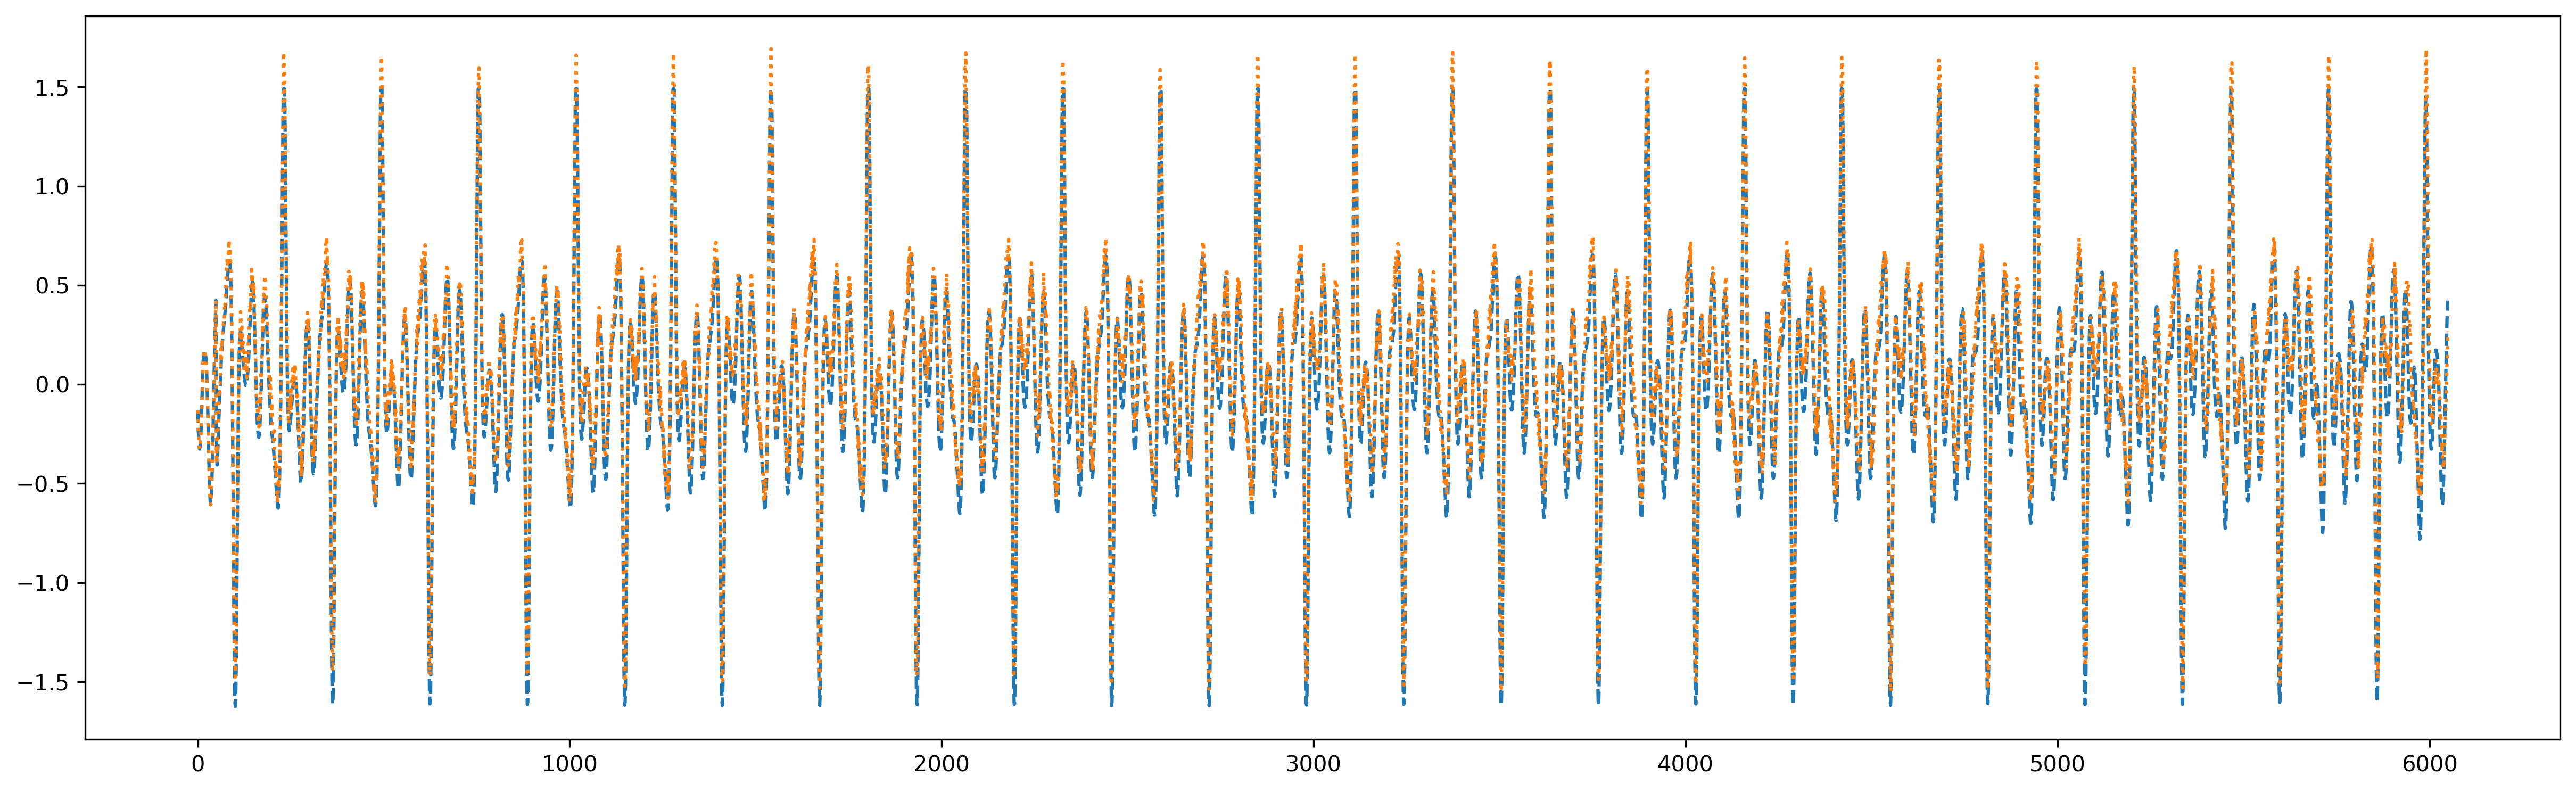

In [6]:
plt.figure(figsize=(20, 6),dpi=300)
plt.plot( torch.concat([x[-50:],prediction_list[:]]                                              ).detach().cpu().numpy() ,linestyle='dashed', label="Displacement")
plt.plot( torch.concat([x[-50:],y[:]+torch.rand(size=[pred_hor],device=device)/_divition_factr]  ).detach().cpu().numpy() ,linestyle='dotted', label="Displacement")

plt.savefig(f"Gprediction alpha={_alpha}.png")

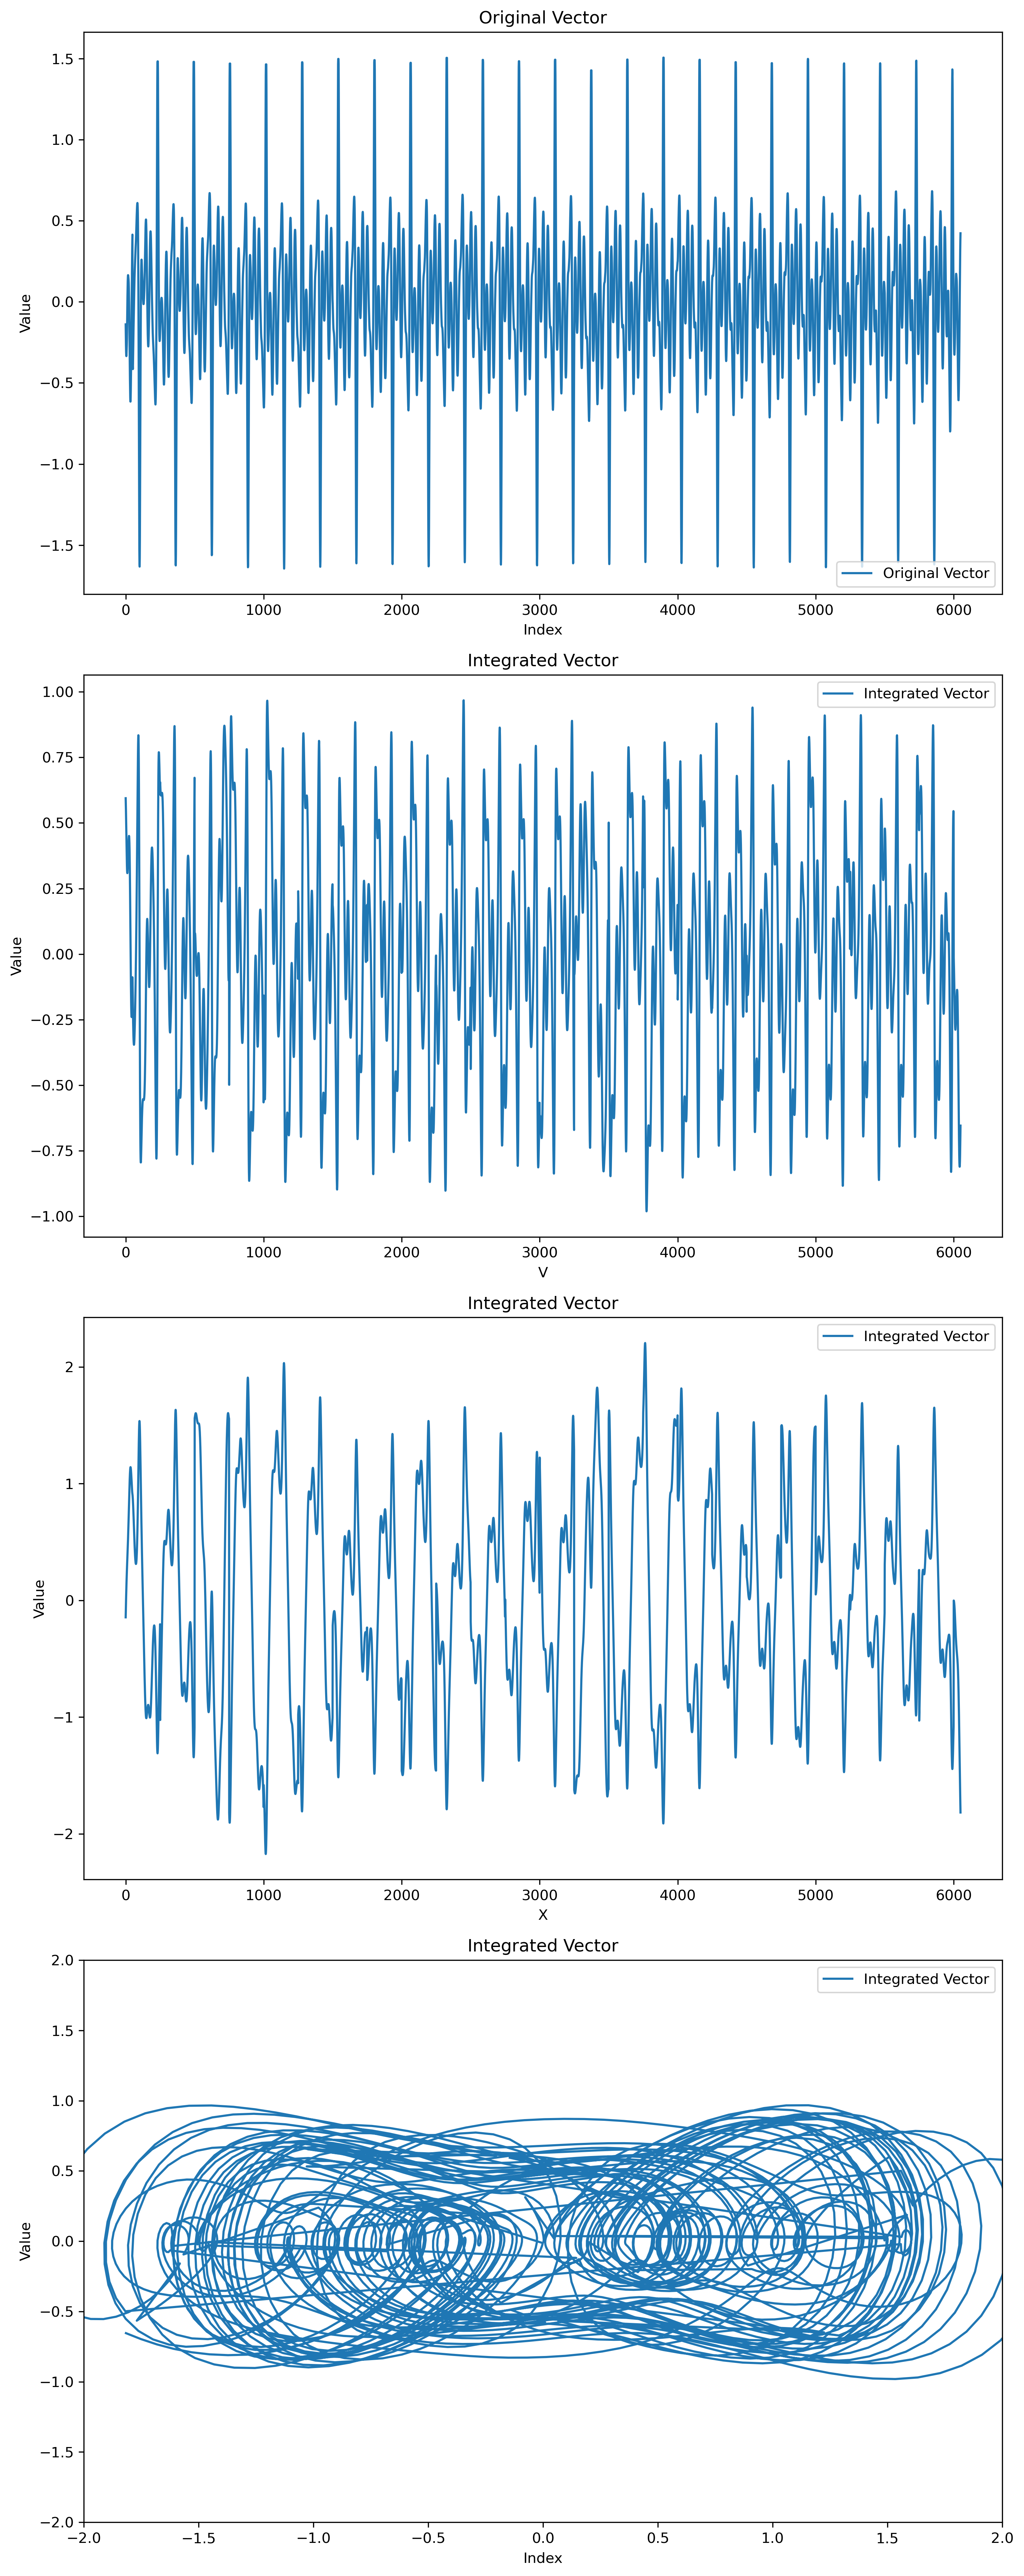

<Figure size 432x288 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def zero_meaner(inp_vec,indexer = 250):
    for i in range(inp_vec.shape[0]//indexer):
        inp_vec[i*indexer:(i+1)*indexer] -= inp_vec[i*indexer:(i+1)*indexer].mean()
    return inp_vec

def integrate_and_plot(vector, dt=0.1):
    vector = zero_meaner(vector)
    # V = np.cumsum((vector - vector.mean())* dt) 
    V = np.cumsum((vector)* dt) 
    V = zero_meaner(V)

    # X = np.cumsum((V-V.mean())* dt) 
    X = np.cumsum((V)* dt) 
    X = zero_meaner(X)
    
    plt.figure(figsize=(10,25),dpi=300)
    plt.subplot(4, 1, 1)
    plt.plot(vector, label='Original Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Original Vector')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(V, label='Integrated Vector')
    plt.xlabel('V')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()


    plt.subplot(4, 1, 3)
    plt.plot(X, label='Integrated Vector')
    plt.xlabel('X')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(X,V, label='Integrated Vector')
    limm = 2
    plt.xlim(-limm, limm)
    plt.ylim(-limm, limm)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Integrated Vector')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f"All alpha={_alpha}.png")
# Example usage

vector = torch.concat([x[-50:],prediction_list[:]])[:].detach().cpu().numpy()
integrate_and_plot(vector)
